[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/palsagar/MC_optimal_bet_sizing/blob/main/examples/basic_example_colab.ipynb)

### Demonstration of Monte Carlo Simulator 

#### Implementing required classes and methods

In [8]:
# uncomment line to install in Colab environment
# !pip install numpy pandas matplotlib yfinance 

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from typing import Callable 

class PriceData:
    def __init__(self, instrument :str, start_date:str, end_date:str, re_sample:str="W-THU") -> None:
        self._data = self.fetch_and_clean_data(instrument, start_date, end_date, re_sample)
        self._close = self._data['Close'].copy()
        self._changes = self._data['changes'].copy()

    def fetch_and_clean_data(self, ins:str, start:str, end:str, re_sample:str) -> pd.DataFrame:
        df = yf.download(ins, start=start, end=end) ; 
        df = df.drop(["Open", "High", "Low", "Adj Close", "Volume"],axis=1)
        df = df.resample(re_sample).last()
        df['changes'] = df['Close'] / df['Close'].shift(1)
        clean_data = df.dropna()
        return clean_data

    @property
    def data(self) -> pd.DataFrame:
        return self._data

    @property
    def price_changes(self) -> pd.Series:
        return self._changes

    # add hurst coefficient property, other autocorrelation properties to evaluate distance from random walk

    def plot(self, width:float=12 , height:float=5) -> None:
        plt.style.use('ggplot');
        fig , ax = plt.subplots(2,1,figsize=(width,height), sharex=True);
        ax[0].plot(self._close.index, self._close.values)
        ax[0].set_ylabel('Closing Price History')
        ax[1].plot(self._changes.index, self._changes.values)
        ax[1].set_ylabel('Price Return History')
        fig.tight_layout();  
        return None


class MonteCarloSimulator:
    
    def __init__(self, time_series:PriceData , nbins:int=25) -> None:
        self._ts = time_series.price_changes 
        self._retn_space , self._prob_space = self.compute_return_and_prob_space(nbins)
        self.simulated_paths = None
        self.final_returns = None

    def compute_return_and_prob_space(self, nbins) -> tuple[np.ndarray]:
        return_freqs , edges = np.histogram(self._ts.values, bins=nbins)
        bin_centroids = 0.5*(edges[1:] + edges[:-1])
        return_space = bin_centroids[(return_freqs > 0.)]
        prob_space = (return_freqs[(return_freqs > 0.)]).astype(float)
        prob_space /= np.sum(prob_space)
        
        return return_space , prob_space

    def __repr__(self) -> str:
        return f"{self._ts.info()}"

    @property
    def original_ts(self):
        return self._ts

    @property
    def ts_returns_probs(self):
        return np.vstack([self._retn_space, self._prob_space]).T

    def compute_std_return(self) -> float:
        return np.std(self.final_returns)

    def compute_avg_return(self) -> float:
        return np.mean(self.final_returns)

    def compute_median_return(self) -> float:
        return np.median(self.final_returns)

    def compute_percentile_return(self, pctile) -> float:
        return np.percentile(self.final_returns,pctile)

    def compute_mode_return(self) -> float:
        return_freqs , edges = np.histogram(self.final_returns, bins='auto')
        bin_centroids = 0.5*(edges[1:] + edges[:-1])
        return_space = bin_centroids[(return_freqs > 0.)]
        prob_space = (return_freqs[(return_freqs > 0.)]).astype(float)
        mode_idx = np.argmax(prob_space)
        return np.mean(return_space[mode_idx]) 

    def __call__(self, frac:float, hold_reward_func:Callable[[float],float], 
                 n_paths:int=1000, n_periods:int=100, rng_seed:int=42) -> None:
        sequences = np.zeros((n_paths, n_periods))
        sequences[:,0] = 1.0

        def modify_reward(frac:float, g:Callable[[float],float], reward:float) -> float:
            return (frac*reward) + ((1.0-frac) * g(reward))

        modified_returns = np.array([ modify_reward(frac, hold_reward_func, x) for x in self._retn_space ])
        
        np.random.seed(rng_seed)
        sequences[:,1:] = np.random.choice(modified_returns, size=(n_paths,n_periods-1), p=self._prob_space)
        cumulative_returns = np.cumprod(sequences, axis=1)
        final_returns = np.prod(sequences, axis=1)

        self.simulated_paths , self.final_returns = cumulative_returns , final_returns 
        return None        

    def plot_paths(self, nbins:int=30, size:tuple[int]=(15,5)) -> None:
        n_paths = len(self.final_returns);
        n_periods = len(self.simulated_paths[0,:]) 

        mean = self.compute_avg_return()
        median = self.compute_median_return()
        mode = self.compute_mode_return()    
        btm_pct = np.percentile(self.final_returns,5.0)

        plt.style.use('ggplot');
        fig , ax = plt.subplots(1,2, figsize=size);
        ax[0].set_title(f'{n_paths} Simulated Paths');
        ax[0].semilogy(self.simulated_paths.T, alpha=0.6);
        ax[0].set_xlim(0,n_periods);
        ax[0].set_xlabel('# periods');
        ax[0].set_ylabel('Evolution of 1 unit');

        ax[1].set_title(f'Distribution of Returns after {n_periods} periods');
        ax[1].hist(self.final_returns, bins=nbins, label=f'Mean={mean:.1f}, Median={median:.1f},Mode={mode:.1f}, Bottom 5%ile = {btm_pct:.1f}'); 
        ax[1].set_xlabel('Return');
        ax[1].set_ylabel('# of paths');
        ax[1].legend();

        
        fig.tight_layout();
        return None  


#### Load Nifty price data, plot time series and sequence of returns

[*********************100%***********************]  1 of 1 completed


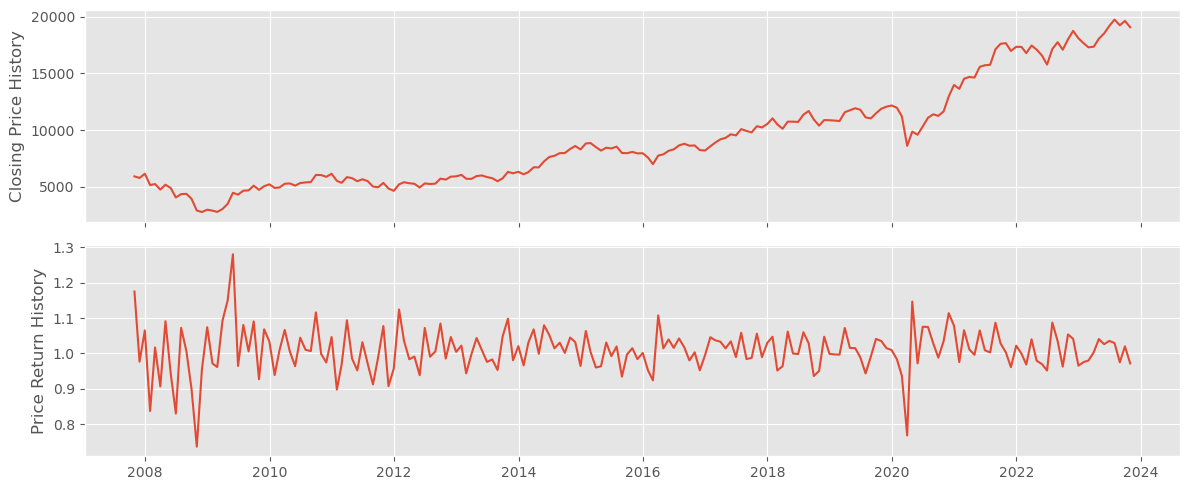

In [2]:
# instantiate object that holds historic price data with instrument name, starting and ending dates
# daily price data resampled to monthly timeframe, with closing price on last day of month used
nifty = PriceData(instrument="^NSEI", start_date="2007-01-01", end_date="2023-11-01", re_sample="M")
# use 'plot' method of object to plot historic price and returns evolution
nifty.plot()

#### Instantiate Monte Carlo Simulator object for Nifty price series

In [3]:
# simulator object can be created directly from the PriceData object
nifty_sim = MonteCarloSimulator(nifty)

#### Simulate MC paths and plot final results

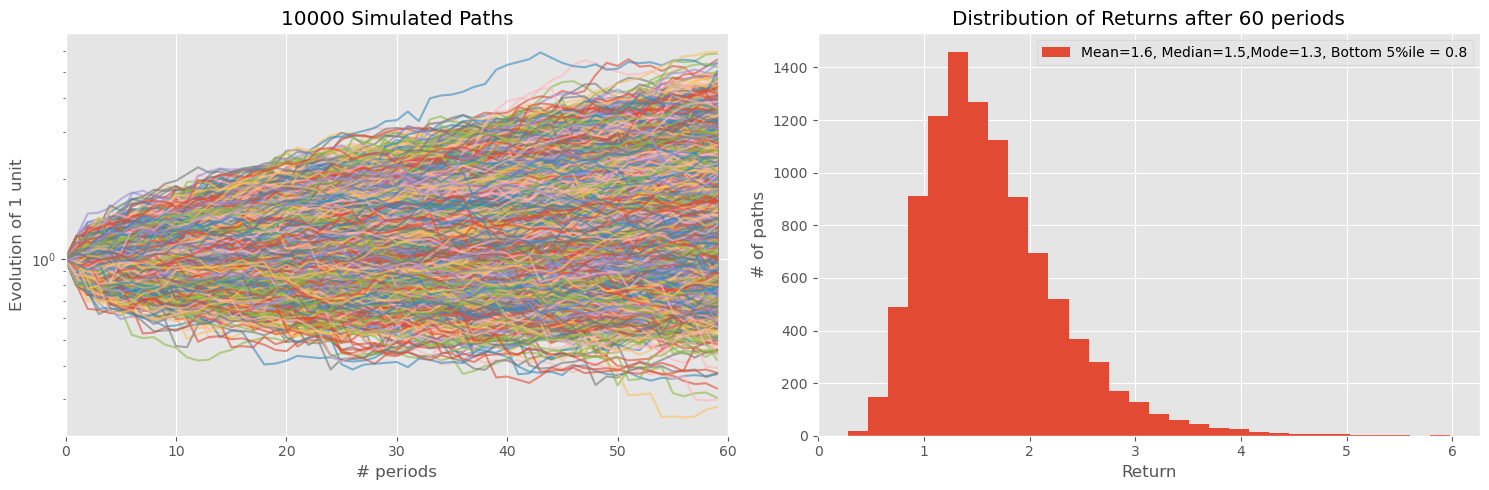

In [4]:
# fraction of total corpus to invest in primary instrument
# implies re-balancing between primary and secondary instrument at beginning of each period
FRACTION = 0.8
# number of paths to simulate for Monte Carlo simulation
NPATHS = 10000
# number of periods to simulate : 5 years * 12 months/year => 5 years of total time 
NPERIODS = int(12*5)

# function : returns of primary instrument -> return of secondary instrument 
# e.g. insurance contract can have 10x return if primary instrument goes down by 20% 
# e.g. in this case, secondary instrument is a fixed income instrument with annual return of 7% 
holding_reward_func = lambda x: 1.0 + (0.07/12.0)

# the simulator object is callable, and it carries out a simple MC simulation
# follows Geometric Brownian Motion (random walk of log returns), autocorrelation is delta function 
nifty_sim(FRACTION, holding_reward_func, n_paths=NPATHS, n_periods=NPERIODS)

# once simulation is done, all paths and final distribution of returns are plotted 
nifty_sim.plot_paths()

##### Compute CAGR and spread of final returns

In [5]:
# helper function to convert final returns to CAGR in percentage
cagr = lambda x,y: f"Median CAGR = {((x**(1.0/y)) - 1.0)*100.0:.2f}%"  

# helper function to compute "spread" of final returns distrubtion
# simple choice is expressing standard deviation in percentage of mean 
spread = lambda x,y: f"Spread (Std/Median) = {(x / y)*100.0:.1f}%"

# uses methods of simulator object to get statitical properties from end of simulation period distribution
print( cagr(nifty_sim.compute_median_return(),5.0) )
print( spread(nifty_sim.compute_std_return() , nifty_sim.compute_median_return()))

Median CAGR = 8.89%
Spread (Std/Median) = 42.4%


#### Let's try a different fraction : 20% primary instrument , 80% fixed return instrument

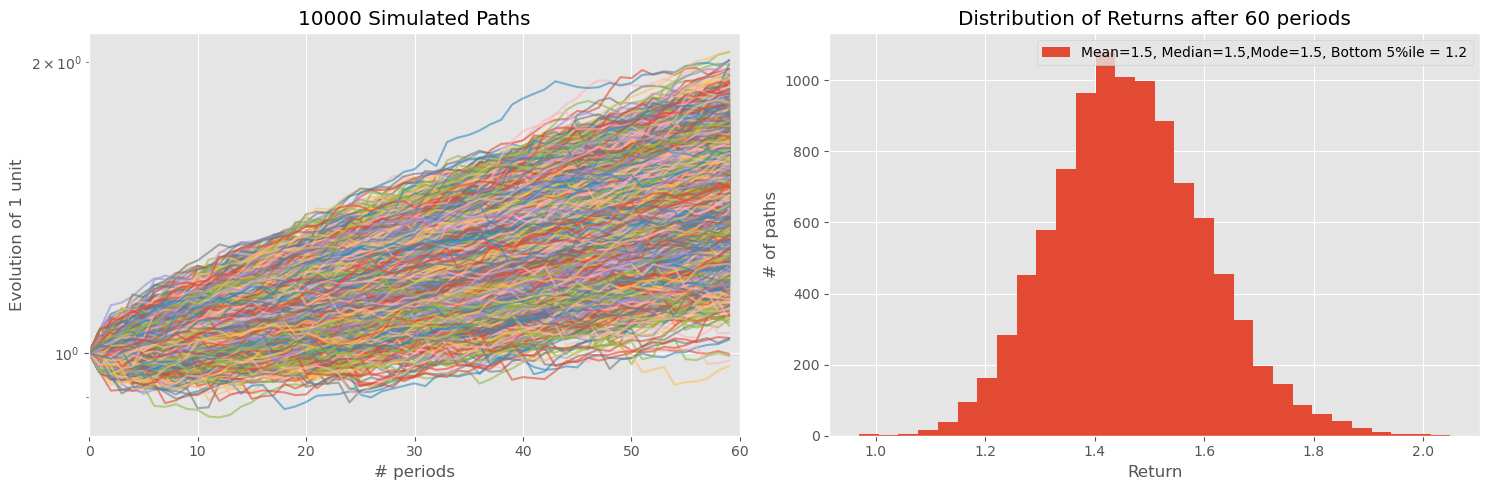

In [6]:
# fraction of total corpus to invest in primary instrument
# implies re-balancing between primary and secondary instrument at beginning of each period
FRACTION = 0.2
# number of paths to simulate for Monte Carlo simulation
NPATHS = 10000
# number of periods to simulate : 5 years * 12 months/year => 5 years of total time 
NPERIODS = int(12*5)

# function : returns of primary instrument -> return of secondary instrument 
# e.g. insurance contract can have 10x return if primary instrument goes down by 20% 
# e.g. in this case, secondary instrument is a fixed income instrument with annual return of 7% 
holding_reward_func = lambda x: 1.0 + (0.07/12.0)

# the simulator object is callable, and it carries out a simple MC simulation
# follows Geometric Brownian Motion (random walk of log returns), autocorrelation is delta function 
nifty_sim(FRACTION, holding_reward_func, n_paths=NPATHS, n_periods=NPERIODS)

# once simulation is done, all paths and final distribution of returns are plotted 
nifty_sim.plot_paths()

#### Let's compare the end of period returns in this case ! 

In [7]:
# uses methods of simulator object to get statitical properties from end of simulation period distribution
print( cagr(nifty_sim.compute_median_return(),5.0) )
print( spread(nifty_sim.compute_std_return() , nifty_sim.compute_median_return()))

Median CAGR = 7.82%
Spread (Std/Median) = 9.6%


#### Some takeaways
- Although the $80:20$ (nifty index : fixed income) bet sizing has slightly higher median returns (CAGR of $8.9\%$ instead of $7.8\%$) than the $20:80$ case, the returns distribution has significantly higher spread ($42\%$ vs $9\%$).

- A starker constrast appears when looking at the worst outcomes i.e. bottom 5 percentile paths, where the $80:20$ case loses $20\%$ at the end of 5 years, compared to the gain of $20\%$ for the $20:80$ case. 

- Optimal "bet" size is not quite obvious, trade-offs exist i.e. slightly higher median CAGR comes at the cost of significantly worse spread as well as worst case outcomes (bottom 5 percentile paths). 